In [5]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [ ]:
# Import necessary modules
#import geopandas as gpd
#import geocube    
#from mpl_toolkits.basemap import Basemap
#from matplotlib import pyplot as plt
import rasterio

import matplotlib.pyplot as plt

import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature  
from matplotlib import pyplot
#import rasterstats
import regionmask
import xarray as xr
import xesmf as xe

import geopandas as gpd

#import rasterstats as rs

import numpy as np

Plot the World bank basins dataset  

DriverError: Major_Basins_of_the_World.dbf: No such file or directory

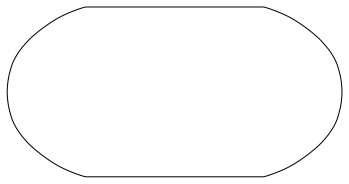

In [13]:
ax = plt.axes(projection=ccrs.Robinson())
shape_feature = ShapelyFeature(Reader('Major_Basins_of_the_World.dbf').geometries(),
                                ccrs.PlateCarree(), edgecolor='black')
ax.add_feature(shape_feature, facecolor='blue')
plt.show()

Use test_data.nc as an example (This could be the "change" map)

In [9]:
era5 = xr.open_dataset('era_runoff_mean.nc')


FileNotFoundError: [Errno 2] No such file or directory: b'/home/jovyan/nicoleta/futuredrought/era_runoff_mean.nc'

Read in again the basins data as geopandas dataframe

In [5]:
# Set filepath 
fp = 'Major_Basins_of_the_World.dbf'

# Read file using gpd.read_file()
basins = gpd.read_file(fp)
basins.head()



,BASWC4_ID,ID,N,NAME,CONT,NN,FISH_,ACRES,SOURCETHM,NO_COUNTRI,Q3,CHECKED,LAEA_HA,LAEA_ACRES,LAEA_PRMTR,geometry
0,2,408,11,Indigirka,2,2011,0,0.002,geoff2.dbf,0,None,-1,0.000000e+00,0.0,0.0,"POLYGON ((139.68730 63.93320, 139.82028 64.030..."
1,3,436,14,Kolyma,2,2014,29,0.003,geoff2.dbf,0,None,-1,0.000000e+00,0.0,0.0,"POLYGON ((153.32126 70.87090, 153.33440 70.873..."
2,4,38,36,Yenisey,2,2036,42,0.007,final_draft22.db,0,International catchments,-1,1.916399e+08,473542164.8,10368035.7,"POLYGON ((84.03548 62.48704, 84.03149 62.49136..."
3,5,148,78,Tana,0,0,0,0.000,final_draft22.db,0,International catchments,-1,1.698563e+06,4197148.9,750506.4,"POLYGON ((25.51510 68.64600, 25.40198 68.62086..."
4,6,104,11,Mackenzie,5,5011,53,0.006,final_draft22.db,0,None,5,0.000000e+00,0.0,0.0,"POLYGON ((-136.92070 68.20810, -136.88443 68.2..."


In [6]:
ID_REGION = 2
print(basins.NAME[ID_REGION])

Yenisey


Each basin is going to be indexed in the mask file by its dataframe index (see example for Yenisey below)

In [7]:
get_mask_Yenisey = basins[basins['NAME'] == "Yenisey"].index.values[0]

In [9]:
basins.loc[ID_REGION]

BASWC4_ID                                                     4
ID                                                           38
N                                                            36
NAME                                                    Yenisey
CONT                                                          2
NN                                                         2036
FISH_                                                        42
ACRES                                                     0.007
SOURCETHM                                      final_draft22.db
NO_COUNTRI                                                    0
Q3                                     International catchments
CHECKED                                                      -1
LAEA_HA                                              1.9164e+08
LAEA_ACRES                                          4.73542e+08
LAEA_PRMTR                                           1.0368e+07
geometry      POLYGON ((84.0354843139648

In [12]:
bas = basins[basins['NAME'] == 'Columbia']

List international basins

In [13]:
int_basins = basins[basins['Q3'] == "International catchments"]

Use regionmask to create the rasterized mask from the shapefile (and plot) 

In [14]:
#basins_mask_poly = regionmask.Regions(name = 'basins_mask', numbers = list(range(0,254)), names = list(basins.BASWC4_ID), abbrevs = list(basins.BASWC4_ID), outlines = list(basins.geometry.values[i] for i in range(0,254)))
basins_mask_poly = regionmask.Regions(name = 'basins_mask', numbers = list(range(0,254)), names = list(basins.NAME), abbrevs = list(basins.NAME), outlines = list(basins.geometry.values[i] for i in range(0,254)))
basins_mask_poly.plot()


AttributeError: module 'regionmask' has no attribute 'Regions'

In [17]:
regionmask.__version__

'0.4.0'

Get the basin mask using the data - note: this converts the basins shapefile longitute to data longitude on the fly

In [140]:
basin_mask = basins_mask_poly.mask(data)
basin_mask

<xarray.DataArray 'region' (lat: 192, lon: 288)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8

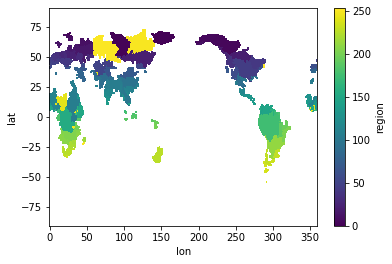

In [141]:
basin_mask.plot()

In [107]:
data

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, member_id: 1)
Coordinates:
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
    season   object ...
Dimensions without coordinates: member_id
Data variables:
    mrro     (member_id, lat, lon) float32 ...

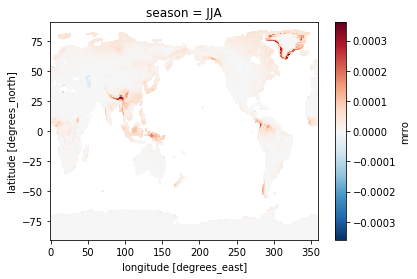

In [19]:
data.mrro.plot()

Select and plot the Columbia River

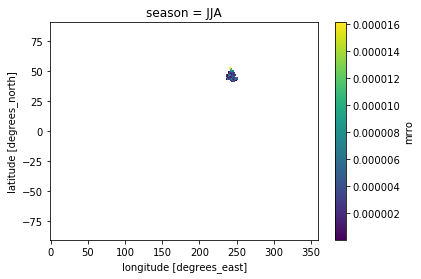

In [20]:
masked_stats = data.where(basin_mask == 36) #Columbia
masked_stats.mrro.plot()

Select and plot Yenisey

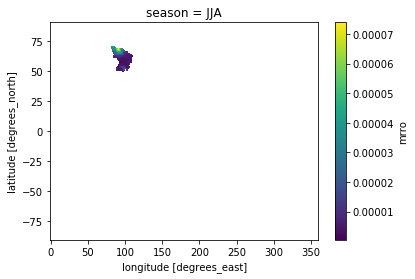

In [21]:
masked_stats = data.where(basin_mask == 2) #Yenisey
masked_stats.mrro.plot()

In [22]:
#basins_mask_poly
temp = list(basins.NAME)
#type(temp)
#temp


/srv/conda/envs/notebook/lib/python3.7/site-packages/cartopy/io/__init__.py:260: DownloadWarning: Downloading: http://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip
  warnings.warn('Downloading: {}'.format(url), DownloadWarning)


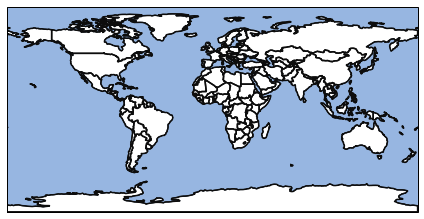

In [23]:
#load states 
regionmask.defined_regions.natural_earth.countries_110.plot(add_label=False);

plt.tight_layout()

In [24]:
mask_countries = regionmask.defined_regions.natural_earth.countries_110.mask(data)

In [265]:
# load the countries data as a geodataframe 


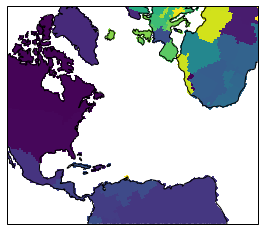

In [27]:
proj=ccrs.LambertConformal(central_longitude=-100)

ax = plt.subplot(111, projection=proj)

low = mask_countries.min()
high = mask_countries.max()

levels = np.arange(low - 0.5, high + 1)

mask_countries.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), levels=levels, add_colorbar=False)

ax.coastlines()

# fine tune the extent
ax.set_extent([250, 360, 0, 75], crs=ccrs.PlateCarree());


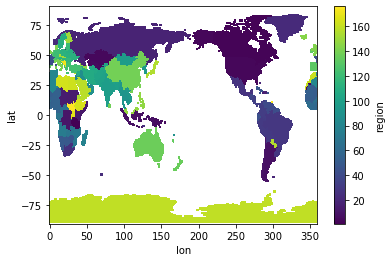

In [28]:
mask_countries.plot()

In [29]:
masked_stats_countries = data.where(mask_countries == 4)

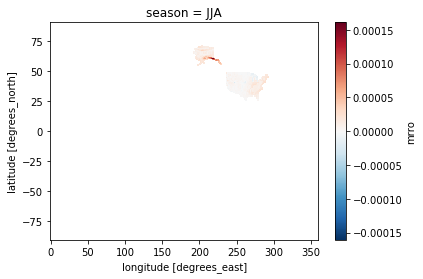

In [30]:
masked_stats_countries.mrro.plot()

In [31]:
url = "http://d2ad6b4ur7yvpq.cloudfront.net/naturalearth-3.3.0/ne_110m_land.geojson"
df = gpd.read_file(url)

In [32]:
df

,scalerank,featureclass,geometry
0,1,Country,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,1,Country,"POLYGON ((-159.20818 -79.49706, -161.12760 -79..."
2,1,Country,"POLYGON ((-45.15476 -78.04707, -43.92083 -78.4..."
3,1,Country,"POLYGON ((-121.21151 -73.50099, -119.91885 -73..."
4,1,Country,"POLYGON ((-125.55957 -73.48135, -124.03188 -73..."
...,...,...,...
122,1,Country,"POLYGON ((51.13619 80.54728, 49.79368 80.41543..."
123,1,Country,"POLYGON ((99.93976 78.88094, 97.75794 78.75620..."
124,1,Country,"POLYGON ((-87.02000 79.66000, -85.81435 79.336..."
125,1,Country,"POLYGON ((-68.50000 83.10632, -65.82735 83.028..."


In [37]:
path_countries = 'countries/ne_110m_admin_0_countries.shp'
# Read file using gpd.read_file()
countries = gpd.read_file(path_countries)
countries.head()


,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,Admin-0 country,1,3,United Republic of Tanzania,TZA,0,2,Sovereign country,United Republic of Tanzania,TZA,...,탄자니아,Tanzania,Tanzania,Tanzânia,Танзания,Tanzania,Tanzanya,Tanzania,坦桑尼亚,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,Admin-0 country,1,7,Western Sahara,SAH,0,2,Indeterminate,Western Sahara,SAH,...,서사하라,Westelijke Sahara,Sahara Zachodnia,Saara Ocidental,Западная Сахара,Västsahara,Batı Sahra,Tây Sahara,西撒哈拉,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,Admin-0 country,1,2,Canada,CAN,0,2,Sovereign country,Canada,CAN,...,캐나다,Canada,Kanada,Canadá,Канада,Kanada,Kanada,Canada,加拿大,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,Admin-0 country,1,2,United States of America,US1,1,2,Country,United States of America,USA,...,미국,Verenigde Staten van Amerika,Stany Zjednoczone,Estados Unidos,Соединённые Штаты Америки,USA,Amerika Birleşik Devletleri,Hoa Kỳ,美国,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


In [38]:
 countries[countries['NAME'] == "Fiji"]

,featurecla,scalerank,LABELRANK,SOVEREIGNT,SOV_A3,ADM0_DIF,LEVEL,TYPE,ADMIN,ADM0_A3,...,NAME_KO,NAME_NL,NAME_PL,NAME_PT,NAME_RU,NAME_SV,NAME_TR,NAME_VI,NAME_ZH,geometry
0,Admin-0 country,1,6,Fiji,FJI,0,2,Sovereign country,Fiji,FJI,...,피지,Fiji,Fidżi,Fiji,Фиджи,Fiji,Fiji,Fiji,斐濟,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."


In [39]:
get_mask_co = countries[countries['NAME'] == "United States of America"].index.values[0]

In [40]:
get_mask_co

4

In [75]:
#upload netcdf data series 

data_ts = xr.open_dataset('ScenarioMIP.NCAR.CESM2.ssp585.day.gn.95_99.nc')
data_ts 

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1825)
Coordinates:
  * time     (time) object 2095-01-01 00:00:00 ... 2099-12-31 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Data variables:
    mrro     (time, lat, lon) float64 ...

In [76]:
masked_stats_ts = data_ts.where(basin_mask == 36) #Columbia
masked_stats_ts

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1825)
Coordinates:
  * time     (time) object 2095-01-01 00:00:00 ... 2099-12-31 00:00:00
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
Data variables:
    mrro     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

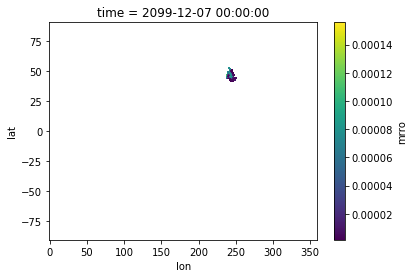

In [77]:
masked_stats_ts.mrro.isel(time = 1800).plot()

In [94]:
lat = basin_mask.lat.values
lon = basin_mask.lon.values

ID_BASIN = 36 #Columbia

sel_mask = basin_mask.where(basin_mask == ID_BASIN).values
sel_mask

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [95]:
lon.shape

(288,)

In [97]:
ID_BASIN

36

In [98]:
id_lon = lon[np.where(~np.all(np.isnan(sel_mask), axis=0))]
id_lat = lat[np.where(~np.all(np.isnan(sel_mask), axis=1))]

In [99]:
out_sel = data_ts.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], id_lon[-1])).compute().where(basin_mask == ID_BASIN)

In [100]:
out_sel

<xarray.Dataset>
Dimensions:  (lat: 12, lon: 11, time: 1825)
Coordinates:
  * lat      (lat) float64 41.94 42.88 43.82 44.76 ... 49.48 50.42 51.36 52.3
  * lon      (lon) float64 237.5 238.8 240.0 241.2 ... 246.2 247.5 248.8 250.0
  * time     (time) object 2095-01-01 00:00:00 ... 2099-12-31 00:00:00
Data variables:
    mrro     (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan

In [101]:
out_sel1 = data.sel(lat = slice(id_lat[0], id_lat[-1]), lon = slice(id_lon[0], id_lon[-1])).compute().where(basin_mask == ID_BASIN)

In [102]:
type(out_sel1)

xarray.core.dataset.Dataset

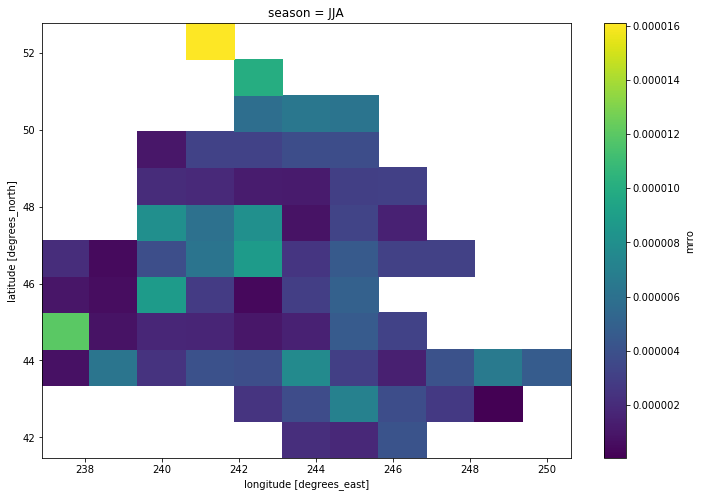

In [105]:
plt.figure(figsize=(12,8))
ax = plt.axes()
out_sel1.mrro.plot()
#out_sel.mrro.isel(time = 1800).plot(ax = ax)
basins.plot(ax = ax, alpha = 0.8, facecolor = 'none')

In [128]:
x = out_sel.mean(dim=['lat','lon'])
y = x.resample(time='M').mean()

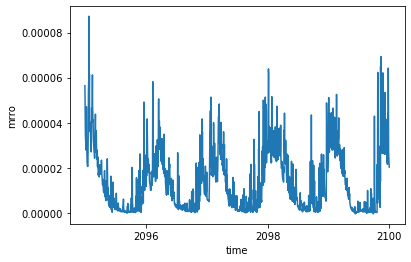

In [123]:
x.mrro.plot()

In [129]:
y

<xarray.Dataset>
Dimensions:  (time: 60)
Coordinates:
  * time     (time) object 2095-01-31 00:00:00 ... 2099-12-31 00:00:00
Data variables:
    mrro     (time) float64 3.831e-05 3.698e-05 ... 3.559e-05 3.141e-05

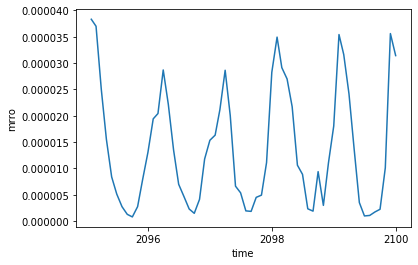

In [131]:
y.mrro.plot()

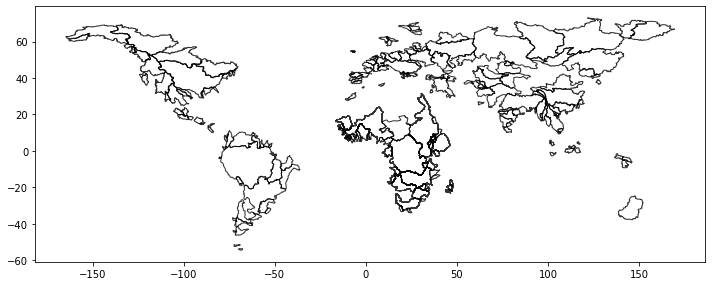

In [132]:
#plot basins
plt.figure(figsize=(12,8))
ax = plt.axes()
basins.plot(ax = ax, alpha = 0.8, facecolor = 'none')

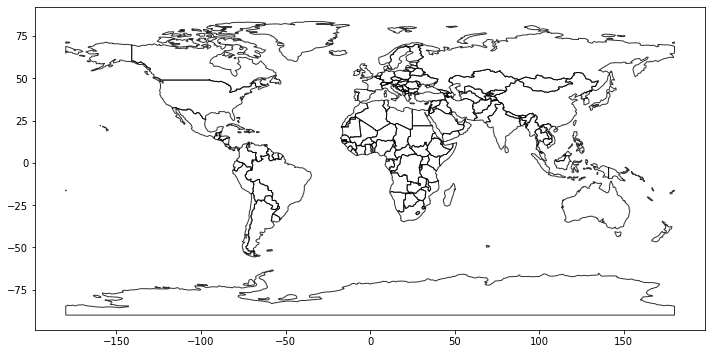

In [134]:
plt.figure(figsize=(12,8))
ax = plt.axes()
countries.plot(ax = ax, alpha = 0.8, facecolor = 'none')